<a href="https://colab.research.google.com/github/SwagataJ/machine-learning-concepts/blob/main/Swagata_Jana_Capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



#**Multi-Label Classification**

---


###Problem Statement
Create a multi-label genre classification model using Tensorflow that automatically assigns genre names looking at the summary of the movie.

1. Use pre-built embeddings for your data dictionary
2. Train the model using Transformer/Attention based architecture
3. Reach an overall “precision” score of 70%
4. Use TF serving to deploy the model as an API (on local)
5. Build a TF serving client to interact with the API. This client should also be able to continuously accept data entered by the user and provide the genre for the chat entered by the end-user.



---



---

### Dataset

CMU Movie Summary Corpus - http://www.cs.cmu.edu/~ark/personas/
Or download from - http://www.cs.cmu.edu/~ark/personas/data/MovieSummaries.tar.gz



---


### Approach
1. We have used pre-trained BERT model from [Tenorflow Hub](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4) and finetuned it to match the number of classes i.e. genres
2. Serving is done using [Tensorflow Model Serve](https://www.tensorflow.org/tfx/guide/serving)
3. Client is build using Flask and port forwarding is done using [ngrok](https://ngrok.com/) / [flask-ngrok](https://pypi.org/project/flask-ngrok/)

#**Importing the Libraries**

In [ ]:
import pandas as pd
import numpy as np
import json
import nltk
import re
import csv
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
from sklearn.model_selection import train_test_split
%matplotlib inline

#**Model 1**

#**Fetching Data**

In [ ]:
!wget http://www.cs.cmu.edu/~ark/personas/data/MovieSummaries.tar.gz

--2022-10-20 06:17:30--  http://www.cs.cmu.edu/~ark/personas/data/MovieSummaries.tar.gz
Resolving www.cs.cmu.edu (www.cs.cmu.edu)... 128.2.42.95
Connecting to www.cs.cmu.edu (www.cs.cmu.edu)|128.2.42.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48002242 (46M) [application/x-gzip]
Saving to: ‘MovieSummaries.tar.gz’

MovieSummaries.tar. 100%[===================>]  45.78M  3.32MB/s    in 14s     

2022-10-20 06:17:45 (3.19 MB/s) - ‘MovieSummaries.tar.gz’ saved [48002242/48002242]



In [ ]:
!tar -xvzf MovieSummaries.tar.gz

MovieSummaries/
MovieSummaries/tvtropes.clusters.txt
MovieSummaries/name.clusters.txt
MovieSummaries/plot_summaries.txt
MovieSummaries/README.txt
MovieSummaries/movie.metadata.tsv
MovieSummaries/character.metadata.tsv


#**Data Exploration and Pre-processing**

In [ ]:
import pandas as pd

In [ ]:
movie_metadata=pd.read_csv('/content/MovieSummaries/movie.metadata.tsv',sep='\t', header=None)#names=movie_metadata_names)



---



---


There are no headers in this dataset. The first column is the **unique movie id**, the third column is the **name of the movie**, and the last column is the **movie genre(s)**. We will not use the rest of the columns in this analysis.



---



---



---



In [ ]:
movie_metadata

,0,1,2,3,4,5,6,7,8
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"
...,...,...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}"
81737,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/03rt9"": ""Ireland"", ""/m/07ssc"": ""United Ki...","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0..."
81738,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}"
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ..."


In [ ]:
#Naming all the Headers
movie_metadata_names=[ "Wikipedia movie ID",
"Freebase movie ID",
"Movie_name",
"Movie_release date",
"Movie_box office revenue",
"Movie_runtime",
"Movie_languages",
"Movie_countries",
"Movie_genres"]

In [ ]:
movie_metadata=pd.read_csv('/content/MovieSummaries/movie.metadata.tsv',sep='\t', names=movie_metadata_names)

In [ ]:
movie_metadata


,Wikipedia movie ID,Freebase movie ID,Movie_name,Movie_release date,Movie_box office revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"
...,...,...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}"
81737,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/03rt9"": ""Ireland"", ""/m/07ssc"": ""United Ki...","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0..."
81738,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}"
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ..."




---



---


Out of 9 columns we need only 2 of them for our classification.

*   **Movie ID**
*   **Movie Genres**


---



---



---





In [ ]:
#Dropping all the unwanted columns 
movie_metadata=movie_metadata.drop(columns=["Freebase movie ID",
"Movie_name",
"Movie_release date",
"Movie_box office revenue",
"Movie_runtime",
"Movie_languages",
"Movie_countries",])

In [ ]:
movie_metadata

,Wikipedia movie ID,Movie_genres
0,975900,"{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,"{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,"{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,"{""/m/07s9rl0"": ""Drama""}"
...,...,...
81736,35228177,"{""/m/07s9rl0"": ""Drama""}"
81737,34980460,"{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0..."
81738,9971909,"{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}"
81739,913762,"{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ..."


In [ ]:
movie_metadata["Movie_genres"] = movie_metadata["Movie_genres"].map(lambda genres: list(eval(genres).values()))



---



---


We can’t access the genres in this row by using just .values( ). This is because this text is a string, not a dictionary. We will have to convert this string into a dictionary. We will take the help of the json library here




---



---



In [ ]:
movie_metadata

,Wikipedia movie ID,Movie_genres
0,975900,"[Thriller, Science Fiction, Horror, Adventure,..."
1,3196793,"[Mystery, Biographical film, Drama, Crime Drama]"
2,28463795,"[Crime Fiction, Drama]"
3,9363483,"[Thriller, Erotic thriller, Psychological thri..."
4,261236,[Drama]
...,...,...
81736,35228177,[Drama]
81737,34980460,"[Biographical film, Drama, Documentary]"
81738,9971909,"[Satire, Comedy]"
81739,913762,"[Science Fiction, Japanese Movies, Adventure, ..."


#**Loading Plot Summary**


---

---



Now, we will load the movie plot dataset into memory. This data comes in a text file with each row consisting of a movie id and a plot of the movie. We will read it line-by-line:


---



---



In [ ]:
plot_summaries=pd.read_csv('/content/MovieSummaries/plot_summaries.txt',sep='\t',names=["Wikipedia movie ID","Summary"])

In [ ]:
plot_summaries #Matching Plot summaries with the Movie ID

,Wikipedia movie ID,Summary
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...
...,...,...
42298,34808485,"The story is about Reema , a young Muslim scho..."
42299,1096473,"In 1928 Hollywood, director Leo Andreyev look..."
42300,35102018,American Luthier focuses on Randy Parsons’ tra...
42301,8628195,"Abdur Rehman Khan , a middle-aged dry fruit se..."


**Merging** the summary with Movie data

In [ ]:
dataset = pd.merge(movie_metadata,plot_summaries,on="Wikipedia movie ID")

In [ ]:
dataset

,Wikipedia movie ID,Movie_genres,Summary
0,975900,"[Thriller, Science Fiction, Horror, Adventure,...","Set in the second half of the 22nd century, th..."
1,9363483,"[Thriller, Erotic thriller, Psychological thri...",A series of murders of rich young women throug...
2,261236,[Drama],"Eva, an upper class housewife, becomes frustra..."
3,18998739,"[Family Film, Fantasy, Adventure, World cinema]","Every hundred years, the evil Morgana returns..."
4,6631279,"[Romantic comedy, Ensemble Film, Comedy-drama,...","Adam, a San Francisco-based artist who works a..."
...,...,...,...
42199,23851782,"[Crime Fiction, Thriller, Comedy, Supernatural]",{{plot}} The film opens with a Great Western e...
42200,35228177,[Drama],Two former National Oceanic Atmospheric Admini...
42201,34980460,"[Biographical film, Drama, Documentary]",{{No plot}} This film follows 12 years in the ...
42202,913762,"[Science Fiction, Japanese Movies, Adventure, ...","The story takes place in the year 2092,The Sup..."


In [ ]:
dataset["Summary"]=dataset["Summary"].str.replace("{{No plot}}","")
dataset["Summary"]=dataset["Summary"].str.replace("{{plot}}","")
dataset["Summary"]=dataset["Summary"].str.lower()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [ ]:
dataset

,Wikipedia movie ID,Movie_genres,Summary
0,975900,"[Thriller, Science Fiction, Horror, Adventure,...","set in the second half of the 22nd century, th..."
1,9363483,"[Thriller, Erotic thriller, Psychological thri...",a series of murders of rich young women throug...
2,261236,[Drama],"eva, an upper class housewife, becomes frustra..."
3,18998739,"[Family Film, Fantasy, Adventure, World cinema]","every hundred years, the evil morgana returns..."
4,6631279,"[Romantic comedy, Ensemble Film, Comedy-drama,...","adam, a san francisco-based artist who works a..."
...,...,...,...
42199,23851782,"[Crime Fiction, Thriller, Comedy, Supernatural]",the film opens with a great western express s...
42200,35228177,[Drama],two former national oceanic atmospheric admini...
42201,34980460,"[Biographical film, Drama, Documentary]",this film follows 12 years in the lives of 3 ...
42202,913762,"[Science Fiction, Japanese Movies, Adventure, ...","the story takes place in the year 2092,the sup..."


In [ ]:
# unique geners
genres = dataset["Movie_genres"].explode().unique().tolist()

In [ ]:
dataset

,Wikipedia movie ID,Movie_genres,Summary
0,975900,"[Thriller, Science Fiction, Horror, Adventure,...","set in the second half of the 22nd century, th..."
1,9363483,"[Thriller, Erotic thriller, Psychological thri...",a series of murders of rich young women throug...
2,261236,[Drama],"eva, an upper class housewife, becomes frustra..."
3,18998739,"[Family Film, Fantasy, Adventure, World cinema]","every hundred years, the evil morgana returns..."
4,6631279,"[Romantic comedy, Ensemble Film, Comedy-drama,...","adam, a san francisco-based artist who works a..."
...,...,...,...
42199,23851782,"[Crime Fiction, Thriller, Comedy, Supernatural]",the film opens with a great western express s...
42200,35228177,[Drama],two former national oceanic atmospheric admini...
42201,34980460,"[Biographical film, Drama, Documentary]",this film follows 12 years in the lives of 3 ...
42202,913762,"[Science Fiction, Japanese Movies, Adventure, ...","the story takes place in the year 2092,the sup..."


In [ ]:
Movie_genres = dataset["Movie_genres"]

In [ ]:
# get all genre tags in a list
genres = sum(Movie_genres,[])
len(set(genres))

363

#**Data Exploration and Pre-processing**

In [ ]:
import nltk 
import matplotlib.pyplot as plt 
import seaborn as sns

In [ ]:
genres = nltk.FreqDist(genres)
genres_df = pd.DataFrame({'Genre': list(genres.keys()), 'Count': list (genres.values())})

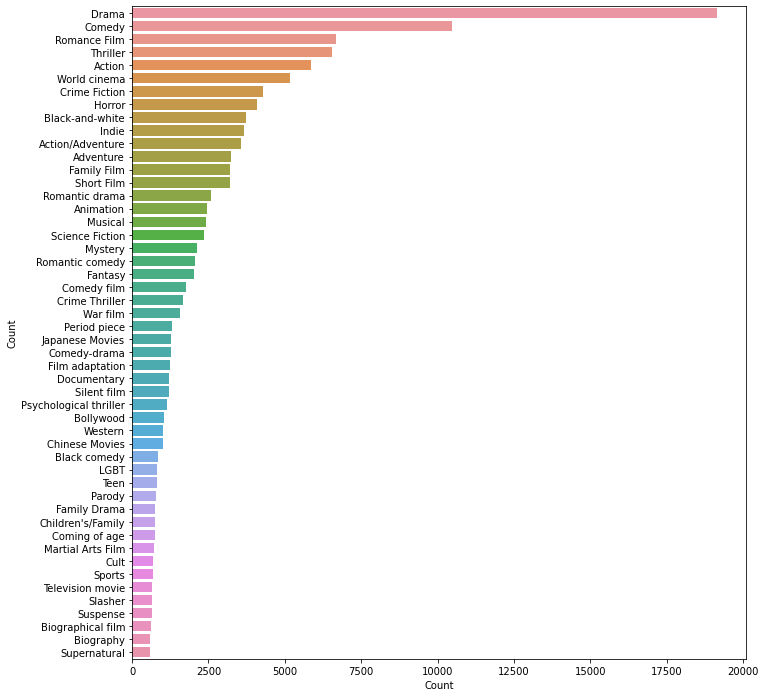

In [ ]:
g = genres_df.nlargest(columns="Count", n = 50) 
plt.figure(figsize=(11,12))
ax = sns.barplot(data=g, x= "Count", y = "Genre")
ax.set(ylabel = 'Count')
plt.show()

In [ ]:
len(genres)

363

**There are over 364 unique genre tags in our dataset**

In [ ]:
dataset = dataset.drop('Wikipedia movie ID', axis=1) #Dropping Movie ID column as we do not need it now

## **One Hot Encoding**

In [ ]:
dataset=dataset.drop('Movie_genres', 1).join(dataset["Movie_genres"].str.join('|').str.get_dummies()) #One Hot Encoding

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


In [ ]:
dataset.head()

,Summary,Absurdism,Acid western,Action,Action Comedy,Action Thrillers,Action/Adventure,Addiction Drama,Adult,Adventure,...,Werewolf fiction,Western,Whodunit,Women in prison films,Workplace Comedy,World History,World cinema,Wuxia,Z movie,Zombie Film
0,"set in the second half of the 22nd century, th...",0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,a series of murders of rich young women throug...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"eva, an upper class housewife, becomes frustra...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"every hundred years, the evil morgana returns...",0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,"adam, a san francisco-based artist who works a...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
genres_name = dataset.columns

In [ ]:
genres_name =genres_name[1:] #0th column is summary which we do not need 

In [ ]:
genres_name

Index(['Absurdism', 'Acid western', 'Action', 'Action Comedy',
       'Action Thrillers', 'Action/Adventure', 'Addiction Drama', 'Adult',
       'Adventure', 'Adventure Comedy',
       ...
       'Werewolf fiction', 'Western', 'Whodunit', 'Women in prison films',
       'Workplace Comedy', 'World History', 'World cinema', 'Wuxia', 'Z movie',
       'Zombie Film'],
      dtype='object', length=363)

**Deleting all the Genres who has less then 20 value in it**

In [ ]:
def deleteData(dataset,genres_name,threshold=20):
  for name in genres_name:
    if dataset[name].value_counts()[1]<=threshold:
        dataset=dataset.drop(name,axis=1)
  return dataset

In [ ]:
dataset=deleteData(dataset,genres_name,20)

In [ ]:
genres_name = dataset.columns
genres_name=genres_name[1:]

In [ ]:
genres_name

Index(['Absurdism', 'Action', 'Action Comedy', 'Action Thrillers',
       'Action/Adventure', 'Addiction Drama', 'Adult', 'Adventure',
       'Adventure Comedy', 'Airplanes and airports',
       ...
       'Tollywood', 'Tragedy', 'Tragicomedy', 'War film', 'Western',
       'Whodunit', 'Workplace Comedy', 'World cinema', 'Wuxia', 'Zombie Film'],
      dtype='object', length=213)



*   Before we have **364 Genres** in total

> ------------------------------------


*   After droppping we have **213 Genres**



In [ ]:
num_classes=len(genres_name)

In [ ]:
 for name in genres_name:
   print(dataset[name].value_counts()[1])


79
5868
142
405
3553
42
117
3248
123
53
97
91
141
43
94
2441
305
32
31
32
351
50
83
386
625
592
365
834
3731
79
1058
51
325
80
100
111
412
244
759
998
116
80
84
10467
78
53
1778
169
212
1261
741
195
77
55
367
184
347
26
231
391
4275
1682
680
204
69
282
225
238
252
1213
172
112
19134
84
349
196
112
170
235
45
34
107
48
766
3219
213
2012
190
196
76
220
1225
524
29
29
338
219
217
264
21
25
45
62
58
58
65
21
27
145
31
63
107
305
358
94
4082
206
29
3668
27
21
1290
62
42
825
21
137
706
25
71
56
499
97
113
168
356
2414
136
175
2119
26
153
57
86
767
1321
24
176
531
78
195
145
130
90
77
1138
23
61
85
60
268
32
40
6666
2075
2572
59
27
532
32
124
2339
246
253
82
3192
1199
518
654
94
101
92
41
56
28
672
342
30
46
134
111
258
571
99
651
104
39
37
63
824
665
6530
77
32
79
51
1556
1021
43
84
5153
79
234


In [ ]:
dataset['label'] = dataset[dataset.columns[1:]].values.tolist()

In [ ]:
dataset = dataset[['Summary', 'label']].copy()

In [ ]:
import re

In [ ]:
def cleanHtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(sentence))
    return cleantext
def cleanPunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    cleaned = cleaned.strip() #Remove spaces at the beginning and at the end of the string
    cleaned = cleaned.replace("\n"," ") 
    return cleaned
def keepAlpha(sentence):
    alpha_sent = ""
    for word in sentence.split():
        alpha_word = re.sub('[^a-z A-Z]+', ' ', word)
        alpha_sent += alpha_word
        alpha_sent += " "
    alpha_sent = alpha_sent.strip()
    return alpha_sent

In [ ]:
dataset['Summary'] = dataset['Summary'].apply(cleanHtml)
dataset['Summary'] = dataset['Summary'].apply(cleanPunc)
dataset['Summary'] = dataset['Summary'].apply(keepAlpha)

In [ ]:
dataset=dataset.convert_dtypes()

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42204 entries, 0 to 42203
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Summary  42204 non-null  string
 1   label    42204 non-null  object
dtypes: object(1), string(1)
memory usage: 2.0+ MB


#**Splitting the Dataset**

---



---
* Train : 80%
* Test : 20%


---



---



---




In [ ]:
# Spliting dataset
train=dataset.sample(frac=0.8)
test= dataset.drop(train.index)

In [ ]:
train

,Summary,label
19172,the story takes place in a remote village wher...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5022,when juliette fontaine formerly a doctor is re...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
22041,robert roy macgregor is a cattle drover and th...,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
29325,the film is about a young man jargo who is of ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
27127,shyama gets a job as a servant so she can pay ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...
28875,the plot involves a teenager frankie who is le...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
20779,the beautiful paradise island melonia is inhab...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4150,the film opens with the same scene from the fi...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9307,terrence mcdonagh is a new orleans police serg...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
test

,Summary,label
1,a series of murders of rich young women throug...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6,serap a young actress with a strong lively per...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7,the story starts as one of the robots flies in...,"[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
15,mary an orphan lives in an orphanage run by nu...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
21,ruby and claude montgomery are a very insecure...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...
42170,karthik is a rich architect in ooty he falls i...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
42172,tom eight and dyslexic he becomes friends with...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
42176,a daytime soap opera star has to deal with his...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
42184,yvonne valbret is a parisian belle who poses a...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


#**Building the Model**
Training model

In [ ]:
import tensorflow as tf 
tf . print(tf. __version__)

2.10.0


In [ ]:
#pip install --ignore-installed --upgrade tensorflow

In [ ]:
tf . print(tf. __version__)

2.10.0


In [ ]:
!pip install tensorflow_text -q --upgrade tensorflow 

Restart runtime if error

In [ ]:
import tensorflow_text as text

In [ ]:
import os
import tensorflow_hub as hub
tf . print(tf. __version__)

2.10.0


**Downloading Model from Tensorflow Hub**

We are using ***BERT model*** and preprocessing/encoder ***T-hub***

In [ ]:
preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4",
    trainable=False)

In [ ]:
#Bert Layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = preprocessor(text_input)
outputs = encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(num_classes, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [ ]:
from tensorflow.keras.utils import plot_model

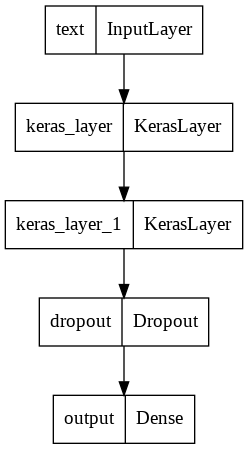

In [ ]:
plot_model(model)

In [ ]:
#Defining Metrics
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]


# Compiling the model with adam optimizers and binary crossentropy as loss
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [ ]:
train_list=train["Summary"].to_list()
test_list=test["Summary"].to_list()

ytrain_list=train["label"].to_list()
ytest_list=test["label"].to_list()

In [ ]:
train_ds=tf.data.Dataset.from_tensor_slices((train_list,ytrain_list))
test_ds =tf.data.Dataset.from_tensor_slices((test_list,ytest_list))

In [ ]:
train_ds = train_ds.shuffle(10000).batch(16, drop_remainder=True)
test_ds = test_ds.shuffle(10000).batch(16, drop_remainder=True)

In [ ]:
model.fit(train_ds,validation_data=test_ds, epochs=10)

Epoch 1/10
2110/2110 [==============================] - 441s 204ms/step - loss: 0.0612 - accuracy: 0.9829 - precision: 0.4326 - recall: 0.0817 - val_loss: 0.0556 - val_accuracy: 0.9840 - val_precision: 0.5898 - val_recall: 0.1354
Epoch 2/10
2110/2110 [==============================] - 429s 204ms/step - loss: 0.0549 - accuracy: 0.9841 - precision: 0.6064 - recall: 0.1251 - val_loss: 0.0537 - val_accuracy: 0.9842 - val_precision: 0.6180 - val_recall: 0.1448
Epoch 3/10
2110/2110 [==============================] - 431s 204ms/step - loss: 0.0533 - accuracy: 0.9842 - precision: 0.6047 - recall: 0.1440 - val_loss: 0.0523 - val_accuracy: 0.9844 - val_precision: 0.6376 - val_recall: 0.1446
Epoch 4/10
2110/2110 [==============================] - 430s 204ms/step - loss: 0.0524 - accuracy: 0.9843 - precision: 0.6053 - recall: 0.1566 - val_loss: 0.0518 - val_accuracy: 0.9844 - val_precision: 0.6362 - val_recall: 0.1533
Epoch 5/10
2110/2110 [==============================] - 429s 203ms/step - loss: 

### Saving model

In [ ]:
version=2
export_path = os.path.join("/content/model", str(version))
tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

In [ ]:
version=2
google_export_path = os.path.join("/content/drive/MyDrive/model", str(version))
tf.keras.models.save_model(
    model,
    google_export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

# Serving

In [ ]:
import os

**Install Tensorflow Serving**

In [ ]:
import sys
# We need sudo prefix if not on a Google Colab.
if 'google.colab' not in sys.modules:
  SUDO_IF_NEEDED = 'sudo'
else:
  SUDO_IF_NEEDED = ''

In [ ]:
install tensorflow server

In [ ]:
!wget 'http://storage.googleapis.com/tensorflow-serving-apt/pool/tensorflow-model-server-universal-2.8.0/t/tensorflow-model-server-universal/tensorflow-model-server-universal_2.8.0_all.deb'
!dpkg -i tensorflow-model-server-universal_2.8.0_all.deb

In [ ]:
os.environ["MODEL_DIR"] = "/content/drive/MyDrive/model/"

In [ ]:
!saved_model_cli show --dir /content/drive/MyDrive/model/2/ --all

**Start running Tensorflow Serving**

In [ ]:
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=multilabel_model \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

In [ ]:
!tail server.log

**Making a request to the model in tensorflow serving**

In [ ]:
os.environ['TENSORFLOW_URL']="http://localhost:8501/v1/models/multilabel_model:predict"

In [ ]:
input_text = "Hundreds of cash-strapped contestants accept an invitation to compete in children's games for a tempting prize, but the stakes are deadly."

In [ ]:
import json
data = json.dumps({"signature_name": "serving_default", "instances": [input_text]})

In [ ]:
import requests
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/multilabel_model:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)

In [ ]:
predictions

In [ ]:
max(sorted(predictions['predictions'][0]))

# Client app

In [ ]:
!rm -rf Capstone

In [ ]:
! git clone https://github.com/GayatriJadhavv/Capstone.git

In [ ]:
import pickle
pickle.dump(genres_name, open('labels.pkl', 'wb'))

In [ ]:
!pip install -r Capstone/requirements.txt -q

In [ ]:
!pip install flask_ngrok pyngrok==4.1.1 -q

In [ ]:
!ngrok authtoken 2GFgDorDUOPkGfm2eLT2tEtdq2e_4Nex9N1cDAjfxzTHKaUeu

In [ ]:
os.environ['pred_threshold']="0.15"

In [ ]:
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=multilable_model \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

In [ ]:
!tail server.log

In [ ]:
!sudo python /content/Capstone/app.py

#**Model 2**

In [ ]:
movie_metadata = pd.read_csv('/content/drive/MyDrive/MovieSummaries/movie.metadata.tsv', sep='\t', header=None)
movie_metadata.head()

In [ ]:
# rename columns
movie_metadata.columns = ["movie_id",1,"movie_name",3,4,5,6,7,"genre"]
movie_metadata.head(2)

In [ ]:
movie_metadata.shape

In [ ]:
plots = []

with open("/content/drive/MyDrive/MovieSummaries/plot_summaries.txt", 'r') as f:
       reader = csv.reader(f, dialect='excel-tab') 
       for row in tqdm(reader):
            plots.append(row)

In [ ]:
len(plots)

Next, split the movie ids and the plots into two separate lists. We will use these lists to form a dataframe

In [ ]:
movie_id = []
plot = []

# extract movie Ids and plot summaries
for i in tqdm(plots):
  movie_id.append(i[0])
  plot.append(i[1])

# create dataframe
movies = pd.DataFrame({'movie_id': movie_id, 'plot': plot})

In [ ]:
movies.head()

#**Data Exploration and Pre-processing**

Let’s add the movie names and their genres from the movie metadata file by merging the latter into the former based on the movie_id column:

In [ ]:
movie_metadata.dtypes

In [ ]:
# change datatype of 'movie_id'
movie_metadata['movie_id'] = movie_metadata['movie_id'].astype(str)

# merge meta with movies
movies = pd.merge(movies, movie_metadata[['movie_id', 'movie_name', 'genre']], on = 'movie_id')

movies.head()

We have added both movie names and genres. However, the genres are in a dictionary notation. It will be easier to work with them if we can convert them into a Python list. We’ll do this using the first row:

In [ ]:
movies['genre'][1]

We can’t access the genres in this row by using just .values( ). This is because this text is a string, not a dictionary. We will have to convert this string into a dictionary. We will take the help of the json library here:

In [ ]:
type(json.loads(movies['genre'][1]))

We can now easily access this row’s genres:

In [ ]:
json.loads(movies['genre'][1]).values()

This code helps us to extract all the genres from the movies data. Once done, add the extracted genres as lists back to the movies dataframe:

In [ ]:
# an empty list
genres = [] 

# extract genres
for i in movies['genre']: 
  genres.append(list(json.loads(i).values())) 

# add to 'movies' dataframe  
movies['genre_new'] = genres

In [ ]:
movies.head(2)

Now the genres are now in a list format.

Some of the samples might not contain any genre tags. We should remove those samples as they won’t play a part in our model building process:

In [ ]:
# remove samples with 0 genre tags
movies_new = movies[~(movies['genre_new'].str.len() == 0)]

In [ ]:
movies_new.shape, movies.shape

So, 411 samples had no genre tags.

Now, let's find how many movie genres have been covered in this dataset:

In [ ]:
# get all genre tags in a list
all_genres = sum(genres,[])
len(set(all_genres))

There are over 363 unique genre tags in our dataset. We will use FreqDist() from the nltk library to create a dictionary of genres and their occurrence count across the dataset:

#**Cleaning the Data**

In [ ]:
# function for text cleaning 
def clean_text(text):
    # remove backslash-apostrophe 
    text = re.sub("\'", "", text) 
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    # remove whitespaces 
    text = ' '.join(text.split()) 
    # convert text to lowercase 
    text = text.lower() 
    
    return text

In [ ]:
movies_new['clean_plot'] = movies_new['plot'].apply(lambda x: clean_text(x))

In [ ]:
movies_new.head(2)

In the clean_plot column, all the text is in lowercase and there are also no punctuation marks

The function below will visualize the words and their frequency in a set of documents. Let’s use it to find out the most frequent words in the movie plots column:



In [ ]:
def freq_words(x, terms=30): 
  all_words = ' '.join([text for text in x]) 
  all_words = all_words.split() 
  fdist = nltk.FreqDist(all_words) 
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
  # selecting top 30 most frequent words 
  d = words_df.nlargest(columns="count", n = terms) 
  
  # visualize words and frequencies
  plt.figure(figsize=(12,15)) 
  ax = sns.barplot(data=d, x= "count", y = "word") 
  ax.set(ylabel = 'Word') 
  plt.show()
  
# print 150 most frequent words 
freq_words(movies_new['clean_plot'], 150)

In [ ]:
# print 100 most frequent words 
freq_words(movies_new['clean_plot'], 100)

Most of the terms in the above plot are stopwords. These stopwords carry far less meaning than other keywords in the text and they just add noise to the data. I’m going to go ahead and remove them from the plots’ text. We can download the list of stopwords from the nltk library:

Most 150 frequent words contains some words wich might be useful for our prediction. So, I'm going to remove most 100 frequent words.

In [ ]:
nltk.download('stopwords')

In [ ]:
# Removing Stopwords
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# function to remove stopwords
#def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

#movies_new['clean_plot'] = movies_new['clean_plot'].apply(lambda x: remove_stopwords(x))

In [ ]:
freq_words(movies_new['clean_plot'], 100)

#**One Hot Encoding**
we will now one hot encode the target variable(i.e. genre_new) by using sklearn’s MultiLabelBinarizer( ). Since there are 363 unique genre tags, there are going to be 363 new target variables.

In [ ]:
#from sklearn.preprocessing import MultiLabelBinarizer

#multilabel_binarizer = MultiLabelBinarizer()
#multilabel_binarizer.fit(movies_new['genre_new'])

# transform target variable
#labels = multilabel_binarizer.transform(movies_new['genre_new'])

In [ ]:
#labels = np.zeros((len(movies_new), 363))
#labels.shape

In [ ]:
#labels

In [ ]:
# Splitting data into train and test dataset
#X_train, X_test, y_train, y_test = train_test_split(movies_new['clean_plot'], labels, test_size=0.2, random_state=42)

#**Building the Model**

In [ ]:
!pip install transformers

In [ ]:
import tensorflow_hub as hub

In [ ]:
# !pip install tensorflow-text

In [ ]:
import tensorflow_text as text

In [ ]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [ ]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embeding([
    "500$ discount. hurry up", 
    "Bhavin, are you up for a volleybal game tomorrow?"]
)

Defining our model to take text as input and adding Dense layer with num_classes as number of node and softmax as activation

In [ ]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(num_classes, activation='softmax', name="output")(l) #this time we are using softmax
                                                                               #No of classes have been reduced to 213
# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [ ]:
model.summary()

In [ ]:
# Defining metrics
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

# Compiling the model with adam optimizers and binary crossentropy as loss
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [ ]:
#Convering list to tensorflow Dataset object

train_list=train["Summary"].to_list()
test_list=test["Summary"].to_list()

ytrain_list=train["label"].to_list()
ytest_list=test["label"].to_list()

train_ds=tf.data.Dataset.from_tensor_slices((train_list,ytrain_list))
test_ds =tf.data.Dataset.from_tensor_slices((test_list,ytest_list))

In [ ]:
# Creating batch and shuffling the data
train_ds = train_ds.shuffle(10000).batch(16, drop_remainder=True)
test_ds = test_ds.shuffle(10000).batch(16, drop_remainder=True)

In [ ]:
# Fitting the model
model.fit(train_ds, validation_data=test_ds, epochs=5)

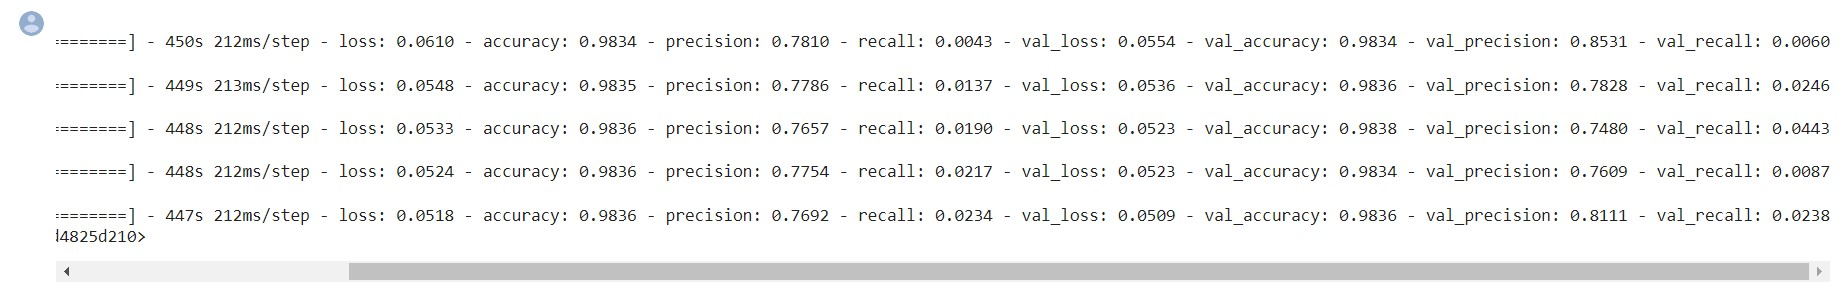

In [ ]:
y_pred = new_bert_model.predict(test_ds)
# y_pred = y_pred.flatten()

In [ ]:
import numpy as np

# Defining threshold to convert the predicted output to 0&1
y_predicted = np.where(y_pred > 0.1, 1, 0)
y_predicted

**Making Predictions**


In [ ]:
print("Predicted genre:" , pd.get_dummies((y_predicted)[4]).idxmax(1))
print("Actual genre: ", pd.get_dummies(dataset_2['Movie genres'][4]).idxmax(1), "\n")

#**Conclusion**
Although precision has been increased by using softmax activation function about 10 percent but prediction are not that good, they are hardly matching with actual genre. So we will keep sigmoid as our activation function.

We were good with previously trained model, so will not proceed further because model is not giving good prediction as compare to previously trained model with sigmoid activation function.